In [1]:
# Import libraries
from dash import Dash, html, callback, Output, Input, State, dcc
from dash.dependencies import ALL
import plotly.express as px
import dash
import json
import Geographical_Plots
from itertools import count

In [2]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

In [3]:
# Define the sectors with colors and associated industries
sectors = [
    {"name": "Technology", "color": "#D32F2F", "industries": ["Software", "Hardware", "IT Services"]},
    {"name": "Healthcare", "color": "#1976D2", "industries": ["Pharmaceuticals", "Medical Devices", "Healthcare Services"]},
    {"name": "Finance", "color": "#388E3C", "industries": ["Banking", "Insurance", "Investment Services"]},
    {"name": "Energy", "color": "#F57C00", "industries": ["Oil & Gas", "Renewable Energy", "Utilities"]},
    {"name": "Consumer Goods", "color": "#512DA8", "industries": ["Food & Beverage", "Household Products", "Apparel"]},
    {"name": "Utilities", "color": "#00796B", "industries": ["Electric", "Water", "Gas"]},
    {"name": "Real Estate", "color": "#C2185B", "industries": ["Residential", "Commercial", "Industrial"]},
    {"name": "Telecommunications", "color": "#689F38", "industries": ["Mobile", "Broadband", "Satellite"]},
    {"name": "Materials", "color": "#0288D1", "industries": ["Chemicals", "Metals & Mining", "Construction Materials"]},
    {"name": "Industrials", "color": "#7B1FA2", "industries": ["Aerospace & Defense", "Machinery", "Industrial Services"]},
    {"name": "Consumer Services", "color": "#AFB42B", "industries": ["Retail", "Travel & Leisure", "Media"]},
    {"name": "Transportation", "color": "#FBC02D", "industries": ["Airlines", "Railroads", "Logistics"]}
]

In [4]:
# Preset the grid container style for reuse
SECTOR_CONTAINER_STYLE = {
    'display': 'none',  # Hidden by default
    'gridTemplateColumns': 'repeat(4, 1fr)',
    'gridTemplateRows': 'repeat(3, 1fr)',
    'gap': '10px',
    'justifyItems': 'center',
    'alignItems': 'center',
    'width': '500px',
    'height': 'auto',  # Allow the container to auto-adjust its height
    'border': '2px solid black',
    'borderRadius': '20px',
    'padding': '10px',
    'boxShadow': '0px 10px 15px rgba(0, 0, 0, 0.2)',
    'backgroundColor': '#f9f9f9',
    'margin': '50px auto'
}

# Preset the "Okay" button style for reuse
OKAY_BUTTON_STYLE = {
    'display': 'none',  # Initially hidden
    'justifyContent': 'center',  # Center horizontally
    'alignItems': 'center',  # Center vertically
    'margin': '20px auto',  # Center the button block itself
    'padding': '10px 20px',  # Remove extra padding
    'fontSize': '16px',
    'fontWeight': 'bold',
    'color': '#fff',
    'backgroundColor': '#007BFF',
    'border': 'none',
    'borderRadius': '5px',
    'cursor': 'pointer',
    'boxShadow': '0px 4px 6px rgba(0, 0, 0, 0.1)',
    'height': '50px',  # Set a fixed height for the button
}



# Preset sector/industry grid style for reuse
TILE_STYLE = {
    'display': 'flex',
    'justifyContent': 'center',
    'alignItems': 'center',
    'border': '2px solid #fff',
    'borderRadius': '15px',
    'boxShadow': '0px 4px 6px rgba(0, 0, 0, 0.1)',
    'fontSize': '14px', 
    'cursor': 'pointer',
    'backgroundColor': '#000000',
    'color': '#fff',
    'textAlign': 'center',
    'fontWeight': 'bold',
    'width': '100px',
    'height': '100px',
    'padding': '5px',
    'textOverflow': 'ellipsis',
    'wordWrap': 'break-word',
    'overflow': 'hidden',
    'transition': 'transform 0.2s, box-shadow 0.2s'
}

In [5]:
# Initial sector tiles
initial_sector_tiles = [
    html.Div(
        sector["name"],
        id={'type': 'sector-box', 'index': i}, 
        n_clicks=0,
        style={
            **TILE_STYLE,
            'backgroundColor': sector["color"]
            },
        className='sector-box'
    ) for i, sector in enumerate(sectors)
]

In [6]:
# Output containe styling
out_text_style = {
    "geography": {'color': '#555', 'fontWeight': 'bold', 'marginBottom': '10px'},
    "sector": {'color': '#28a745', 'marginBottom': '10px'},
    "industry": {'color': '#007bff', 'marginBottom': '10px'}
}

In [7]:
## Initial global plot
fig = Geographical_Plots.plot_global_country().update_layout(clickmode='event+select')
# fig.update_layout(clickmode='event+select')

In [8]:
app = Dash(__name__, external_stylesheets = external_stylesheets)

# App layout
app.layout = html.Div([
    # id is the name used to reference later and data/figure is what it is set to
    dcc.Store(id = 'selected-sectors', data = []),  # Store to keep track of selected sectors
    dcc.Store(id = 'selected-industries', data = []),  # Store to keep track of selected industries
    dcc.Store(id = "selected-geography", data = {}), # Store geographical data
    dcc.Store(id = 'step', data = 'maps1'),  # Track current step: 'sectors' or 'industries'
    dcc.Graph(id = 'map', figure = fig),  # Display scatter plot at the start

    # Large Square Container for sectors or industries
    html.Div(
        id = 'sector-container',
        children = initial_sector_tiles,  # Set the initial children to the sector tiles
        style = SECTOR_CONTAINER_STYLE # Set the style. This block is initially hidden
    ),

    # "Okay" Button
    html.Button('Okay', id = 'okay-button', 
                n_clicks = 0, style = OKAY_BUTTON_STYLE), # This block is initially hidden

    # Output Box for Displaying Selected Sectors and Industries
    html.Div(id = 'display-out', style = {
        'width': '460px', 
        'height': 'auto', 
        'border': '2px solid black', 
        'borderRadius': '10px',
        'padding': '10px', 
        'margin': '20px auto',
        'textAlign': 'center',
        'fontSize': '20px',
        'fontWeight': 'bold',
        'backgroundColor': '#f8f9fa',
        'boxShadow': '0px 4px 6px rgba(0, 0, 0, 0.1)',
        'fontFamily': 'sans-serif',
    })
])

## Single callback function to update the app components
@callback(
    Output('selected-sectors', 'data'), # Selected sectors to keep track of
    Output('sector-container', 'children'), # Sector grid layout updated
    Output('sector-container', 'style'), # Overall grid info to hide or show it
    Output('selected-industries', 'data'), # Selected industries to keep track of
    Output('step', 'data'), # Track which step: 'plot' or 'sectors' or 'industries'
    Output('okay-button', 'style'),  # Okay button info to hide or show it
    Output('map', 'figure'), # Figure in the map plot to update
    Output('map', 'style'), # Plot info to hide or show it
    Output('selected-geography', 'data'), # Selected geographies
    Input('map', 'clickData'), # Clicked data on the plot
    Input({'type': 'sector-box', 'index': ALL}, 'n_clicks'), # Selected sectors from the grid
    Input({'type': 'industry-box', 'index': ALL}, 'n_clicks'), # Selected industries from the grid
    Input('okay-button', 'n_clicks'), # Clicks from okay button
    State('selected-sectors', 'data'), # Selected sectors to keep track of
    State('selected-industries', 'data'), # Selected industries to keep track of
    State('step', 'data'), # Track which step: 'plot' or 'sectors' or 'industries'
    State('selected-geography', 'data')
)
def update_layout(click_data, sector_clicks, industry_clicks, 
                  okay_clicks, selected_sectors, selected_industries, 
                  step, selected_geography):

    # Callback context
    ctx = dash.callback_context

    # If current step is maps1 and the plot was clicked: We display USA or NUTS1 plot
    if step == "maps1" and click_data:

        # Save selected country
        selected_geography["Country"] = click_data["points"][0]["location"]

        # Option 1 is US States
        if selected_geography["Country"] == "USA":
            
            # Plot usa states
            fig = Geographical_Plots.plot_usa_states()
            
            return (selected_sectors, initial_sector_tiles,
                    {'display' : "none"}, # Keep the grid hidden
                    selected_industries, "maps2",
                    {'display' : "none"}, # Keep the button hidden,
                    fig, dash.no_update,
                    selected_geography)

        # Option 2 is NUTS Countries
        elif selected_geography["Country"] in Geographical_Plots.nuts_countries:
            
            # Plots NUTS1
            fig = Geographical_Plots.plot_nuts_country(selected_geography["Country"], 1)
            
            return (selected_sectors, initial_sector_tiles,
                    {'display' : "none"}, # Keep the grid hidden
                    selected_industries, "maps2",
                    {'display' : "none"}, # Keep the button hidden,
                    fig, dash.no_update,
                    selected_geography)

        # Option 3 Return the Sectors
        else:
            
            return (selected_sectors, initial_sector_tiles,
                    {**SECTOR_CONTAINER_STYLE, 'display': 'grid'}, # Show the grid
                    selected_industries, "sectors", 
                    {**OKAY_BUTTON_STYLE, 'display': 'flex'},  # Show the button
                    dash.no_update, {'display': 'none'}, # Hide plot
                    selected_geography)

    # If current step is maps2 and the plot was clicked: We display state or US Cities or NUTS2 plot
    if step == "maps2" and click_data:

        # Option 1 is US States
        if selected_geography["Country"] == "USA":
            
            # Save selected state
            selected_geography["State"] = click_data["points"][0]["location"]

            # Plot usa cities
            fig = Geographical_Plots.plot_usa_subnational(selected_geography["State"])

            return (selected_sectors, initial_sector_tiles,
                    {'display' : "none"}, # Keep the grid hidden
                    selected_industries, "maps3",
                    {'display' : "none"}, # Keep the button hidden,
                    fig, dash.no_update,
                    selected_geography)

        # Option 2 is NUTS Countries
        elif selected_geography["Country"] in Geographical_Plots.nuts_countries:

            # Save selected NUTS2
            selected_geography["NUTS1"] = click_data["points"][0]["location"]

            # Plot NUTS2
            fig = Geographical_Plots.plot_nuts_country(selected_geography["Country"], 2, selected_geography["NUTS1"])

            return (selected_sectors, initial_sector_tiles,
                    {'display' : "none"}, # Keep the grid hidden
                    selected_industries, "maps3",
                    {'display' : "none"}, # Keep the button hidden,
                    fig, dash.no_update,
                    selected_geography)

    # If current step is maps3 and the plot was clicked: We display NUTS3 plot
    if step == "maps3" and click_data:

        # Option 1 is US States
        if selected_geography["Country"] == "USA":

            # Save selected state. This one uses hovertext
            selected_geography["City"] = click_data["points"][0]["hovertext"]

            return (selected_sectors, initial_sector_tiles,
                    {**SECTOR_CONTAINER_STYLE, 'display': 'grid'}, # Show the grid
                    selected_industries, "sectors", 
                    {**OKAY_BUTTON_STYLE, 'display': 'flex'},  # Show the button
                    dash.no_update, {'display': 'none'}, # Hide plot
                    selected_geography)

        # Option 2 is NUTS Countries
        elif selected_geography["Country"] in Geographical_Plots.nuts_countries:

            # Save selected NUTS2
            selected_geography["NUTS2"] = click_data["points"][0]["location"]

            # Plot NUTS3
            fig = Geographical_Plots.plot_nuts_country(selected_geography["Country"], 3, 
                                              selected_geography["NUTS1"], 
                                              selected_geography["NUTS2"])

            return (selected_sectors, initial_sector_tiles,
                    {'display' : "none"}, # Keep the grid hidden
                    selected_industries, "maps4",
                    {'display' : "none"}, # Keep the button hidden,
                    fig, dash.no_update,
                    selected_geography)
        
        
    # If current step is maps4 and the plot was clicked: We hide plot and display the grid and okay button
    # We also save NUTS3
    if step == 'maps4' and click_data:

        # Save selected NUTS2
        selected_geography["NUTS3"] = click_data["points"][0]["location"]
        
        return (selected_sectors, initial_sector_tiles,
                {**SECTOR_CONTAINER_STYLE, 'display': 'grid'}, # Show the grid
                selected_industries, "sectors", 
                {**OKAY_BUTTON_STYLE, 'display': 'flex'},  # Show the button
                dash.no_update, {'display': 'none'}, # Hide plot
                selected_geography)

    # If current step is sector and the grid was clicked: Updated the grid colors to show selection
    if step == 'sectors' and ctx.triggered and 'sector-box' in ctx.triggered[0]['prop_id']:

        # Selected sector on grid
        clicked_index = json.loads(ctx.triggered[0]['prop_id'].split('.')[0])['index']
        selected_sector = sectors[clicked_index]["name"]

        # Toggle the selected sector
        # If a sector is selected add it for tracking
        # If a sector was already selected, deselect it
        if selected_sector in selected_sectors:
            selected_sectors.remove(selected_sector)
        else:
            selected_sectors.append(selected_sector)

        # Update the sector grid with new colors
        updated_sector_children = [
            html.Div(
                sector["name"],
                id = {'type': 'sector-box', 'index': i},
                n_clicks = 0,
                style = {
                    **TILE_STYLE,
                    'backgroundColor': sector["color"] if sector["name"] not in selected_sectors else '#000000',
                    'color': '#fff' if sector["name"] not in selected_sectors else '#00ff00'
                    },
                className = 'sector-box'
            ) for i, sector in enumerate(sectors)
        ]
        
        return (selected_sectors, updated_sector_children, dash.no_update, 
                selected_industries, 'sectors', dash.no_update, 
                dash.no_update, {'display': 'none'}, # Hide plot
                selected_geography)

    
    # If the okay button is pressed and the setp is sectors, we will move on to industries
    # Hide the sector grid and display industry grid of industries in the selected sectors
    if okay_clicks > 0 and step == 'sectors':

        # Update the sector grid with color change
        industry_counter = count() # From itertools that does a global count as we call on next
        updated_industry_children = [
            html.Div(
                industry,
                id = {'type': 'industry-box', 'index': next(industry_counter)},
                n_clicks = 0,
                style = {
                    **TILE_STYLE,
                    'backgroundColor': sector["color"],  # Match industry card to sector color
                },
                className = 'industry-box',
                **{"data-sector-color": sector["color"]}
            )
            for sector in sectors if sector["name"] in selected_sectors
            for industry in sector["industries"]
        ]
        
        return (selected_sectors, updated_industry_children, 
                {**SECTOR_CONTAINER_STYLE, 'display': 'grid'}, # Reload grid container style otherwise it resets
                selected_industries, 'industries', 
                {**OKAY_BUTTON_STYLE, 'display': 'flex'}, # Reload play button style otherwise it resets
                dash.no_update, {'display': 'none'}, # Hide plot
                selected_geography)

    # If current step is industries and the grid was clicked: Updated the grid colors to show selection
    if step == 'industries' and 'industry-box' in ctx.triggered[0]['prop_id']:

        # Selected industry on grid
        clicked_index = json.loads(ctx.triggered[0]['prop_id'].split('.')[0])['index']
        # Identify the selected industry and its sector color
        selected_industry = None
        sector_color = None
        industry_counter = 0
        for sector in sectors:
            if sector["name"] in selected_sectors:
                for industry in sector["industries"]:
                    if industry_counter == clicked_index:
                        selected_industry = industry
                        sector_color = sector["color"]
                        break
                    industry_counter += 1
            if selected_industry:
                break

        # Toggle the selected industry
        # If a industry is selected add it for tracking
        # If a industry was already selected, deselect it
        if selected_industry in selected_industries:
            selected_industries.remove(selected_industry)
        else:
            selected_industries.append(selected_industry)

        # Update the industry grid with the new selection and color change
        industry_counter = count()  # From itertools that does a global count as we call on next
        updated_industry_children = [
            html.Div(
                industry,
                id = {'type': 'industry-box', 'index': next(industry_counter)},
                n_clicks = 0,
                style = {
                    **TILE_STYLE,
                    'backgroundColor': "#000000" if industry in selected_industries else sector["color"],  # Change color if selected
                    'color': "#00ff00" if industry in selected_industries else "#fff",
                },
                className = 'industry-box',
                **{"data-sector-color": sector["color"]}
            )
            for sector in sectors if sector["name"] in selected_sectors
            for industry in sector["industries"]
        ]

        return (selected_sectors, updated_industry_children, dash.no_update, 
                selected_industries, 'industries', dash.no_update, 
                dash.no_update, {'display': 'none'}, # Hide plot
                selected_geography)

    
    # If current step is industries and okay button was clicked: Hide grids and only display the collections
    if okay_clicks > 0 and step == 'industries':
        return (selected_sectors, [], 
                {'display': 'none'}, # Hide grid
                selected_industries, 'end', 
                {'display': 'none'}, # Hide okay button
                dash.no_update, {'display': 'none'}, # Hide plot
                selected_geography)

    # Things remain as is
    return (selected_sectors, dash.no_update, dash.no_update, 
            selected_industries, step, dash.no_update, 
            dash.no_update, dash.no_update,
                selected_geography)

# Callback to display selected sectors and industries
@callback(
    Output('display-out', 'children'), # Selected output display
    Input('okay-button', 'n_clicks'), # Clicks on okay button
    State('selected-sectors', 'data'), # Selected Sectors
    State('selected-industries', 'data'), # Selected Industries
    State('selected-geography', 'data') # Selected geography
)
def handle_okay_click(n_clicks, selected_sectors, selected_industries, selected_geography):
    # Okay has been clicked
    if n_clicks > 0:
        # Default message
        if not selected_sectors and not selected_industries and not selected_geography:
            return "No selections" # Message when there are no selections

        # Initialize empty list to save selections
        selected_items = {}
        if selected_geography: # Sectors are selected
            selected_items["geography"] = f"Selected Location: {', '.join(list(selected_geography.values())[::-1])}"
        if selected_sectors: # Sectors are selected
            selected_items["sector"] = f"Selected Sectors: {', '.join(selected_sectors)}"
        if selected_industries: # Industries are selected
            selected_items["industry"] = f"Selected Industries: {', '.join(selected_industries)}"
        return html.Div([html.P(item, style = out_text_style[name]) for name, item in selected_items.items()])
        
    return "" # Defaut Message

if __name__ == '__main__':
    app.run(debug=True)

In [9]:
import dash
from dash import html, dcc
from dash.dependencies import Input, Output

app = dash.Dash(__name__)

# Define button styles
def get_button_style(selected):
    return {
        'margin': '10px',
        'padding': '10px 20px',
        'backgroundColor': '#007bff' if selected else '#cccccc',
        'color': 'white' if selected else 'black',
        'border': 'none',
        'borderRadius': '5px',
        'cursor': 'pointer'
    }

app.layout = html.Div([
    html.Div([
        html.Button('Sales', id='sales-button', n_clicks=0, style=get_button_style(True)),
        html.Button('Asset', id='asset-button', n_clicks=0, style=get_button_style(False)),
        html.Button('Borrow', id='borrow-button', n_clicks=0, style=get_button_style(False)),
        html.Button('Shrink', id='shrink-button', n_clicks=0, style=get_button_style(False))
    ], style={'textAlign': 'center'}),
    
    # Placeholder for showing current mode
    html.Div(id='current-mode', style={'marginTop': '20px', 'fontSize': '24px', 'textAlign': 'center'})
])

@app.callback(
    [Output('sales-button', 'style'),
     Output('asset-button', 'style'),
     Output('borrow-button', 'style'),
     Output('shrink-button', 'style'),
     Output('current-mode', 'children')],
    [Input('sales-button', 'n_clicks'),
     Input('asset-button', 'n_clicks'),
     Input('borrow-button', 'n_clicks'),
     Input('shrink-button', 'n_clicks')]
)
def update_mode(sales_clicks, asset_clicks, borrow_clicks, shrink_clicks):
    buttons = {
        'Sales': sales_clicks,
        'Asset': asset_clicks,
        'Borrow': borrow_clicks,
        'Shrink': shrink_clicks
    }

    ctx = dash.callback_context

    clicked_id = ctx.triggered[0]['prop_id'].split('.')[0]
    print(clicked_id)
    # Determine which button was clicked the most
    mode = max(buttons, key=buttons.get)
    
    # Update button styles
    return [get_button_style(mode == 'Sales'),
            get_button_style(mode == 'Asset'),
            get_button_style(mode == 'Borrow'),
            get_button_style(mode == 'Shrink'),
            f'Current Mode: {mode}']

if __name__ == '__main__':
    app.run_server(debug=True)




asset-button
borrow-button
shrink-button


In [7]:
# The 4 model type buttons style
[2] * 4 + [3, 4, 5]
pd.DataFrame(Setup.df.to_dict('records'))

,Names,Sales,Asset,Sector,Industry,Country,Size,SalesP,AssetP,ShrinkP,...,Asset_ML_glb_size_sector,Asset_L_glb_size_sector,Borrow_H_glb_size_sector,Borrow_MH_glb_size_sector,Borrow_ML_glb_size_sector,Borrow_L_glb_size_sector,Shrink_H_glb_size_sector,Shrink_MH_glb_size_sector,Shrink_ML_glb_size_sector,Shrink_L_glb_size_sector
0,Name1,1007.942844,1919.938326,Tech,Tech,USA,Large,33,36,27,...,2458,2578,503,68,2063,1230,5312,5916,1256,1338
1,Name2,1219.020236,1797.435172,Finance,Finance,Canada,Medium,29,59,35,...,2463,2535,591,96,1969,1229,5445,5525,1053,1399
2,Name3,986.510785,2034.514102,Retail,Retail,Germany,Small,60,38,60,...,2409,2555,534,100,1973,1234,5710,5409,1089,1304
3,Name4,1016.051798,2134.228225,Healthcare,Healthcare,UK,Large,76,24,66,...,2553,2555,555,94,1986,1281,5770,5743,1178,1095
4,Name5,1044.269784,2205.613988,Tech,Tech,USA,Medium,42,21,47,...,2501,2563,576,62,2046,1262,5567,5602,1261,1394
5,Name6,1062.339144,2369.555241,Finance,Finance,Canada,Small,15,49,18,...,2403,2481,511,89,1927,1278,5268,5789,1247,1078
6,Name7,1100.890349,2169.185205,Retail,Retail,Germany,Large,64,17,7,...,2522,2432,575,147,2099,1253,5584,5339,1086,1365
7,Name8,1039.424879,1877.117878,Healthcare,Healthcare,UK,Medium,76,17,51,...,2528,2453,598,119,2076,1201,5010,5499,1490,1130
8,Name9,966.361330,2010.119621,Tech,Tech,USA,Small,26,56,56,...,2586,2538,592,129,1920,1298,5633,5547,1435,1349
9,Name10,935.409354,2161.582438,Finance,Finance,Canada,Large,56,53,18,...,2519,2516,586,137,1917,1234,5364,5062,1472,1116


In [8]:
([2] * 4 +  # The 4 model type buttons style
[3, 4, 5])

[2, 2, 2, 2, 3, 4, 5]

In [1]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State, ALL
import pandas as pd
import json
import numpy as np
import itertools

import Network_Plots as NPlots
import Driver_Plots as DPlots
import DistMatrix_Plots as DMPlots
import Silhouette_Plots as SPlots
import RadarMeter_Plots as RPlots
import Geographical_Plots as GPlots
import AppSetup
import Setup
from Setup import OKAY_BUTTON_STYLE, SECTOR_CONTAINER_STYLE, COLOR_BUTTON_STYLE, BOX_STYLE_FULL, HOVER_STYLE, PRINT_STYLE, APP_BACKGROUND_COLOR, model_type_list, category_colors, sectors_ndy


## Load in example table of metadata
df = Setup.df

# Sort dataframe by base category order
model = "Sales" # Base model type

df = Setup.model_type_prep(df, model)

INITIAL_POOL = len(df) # Number of firms initially available

# Initialize selected status
initial_selected = {i: False for i in df["Names"]}

# External stylesheets
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# Initialize Dash app
app = dash.Dash(__name__)

app.index_string = Setup.index_string

# Layout of the app
app.layout = html.Div(
    id = "app-container",
    children = [
    # Store relevant state variables
    dcc.Store(id = "selected-status", data = initial_selected),  # Store dict with name status
    dcc.Store(id = "selected-companies", data = []),  # Store selected companies
    dcc.Store(id = "model-mode", data = model), # Store model mode
    dcc.Store(id = "page", data = 0),  # Store current page for grid display
    dcc.Store(id = "dataframe-store", data = df.to_dict('records')),  # Store dataframe as dict
    dcc.Store(id = 'selected-sectors', data = []),  # Store to keep track of selected sectors
    dcc.Store(id = 'selected-industries', data = []),  # Store to keep track of selected industries
    dcc.Store(id = "selected-geography", data = {}), # Store geographical data
    dcc.Store(id = 'step', data = 'maps1'),  # Track current step: 'sectors' or 'industries'
    dcc.Store(id='counter-store', data=INITIAL_POOL), # Track count of available firms
    dcc.Store(id='selected-size', data="Large"), # Store selected size

    # Geographical plots container
    html.Div(
        dcc.Graph(id = 'map', 
                  figure = GPlots.plot_global_country(background_color = APP_BACKGROUND_COLOR).update_layout(clickmode='event+select')),
        style = {'display': 'flex',
                 'justifyContent': 'center',  # Horizontally center the graph
                 'alignItems': 'center', # Vertically center the graph
                'backgroundColor': APP_BACKGROUND_COLOR}  
    ),

    # Sector/NDY Grids
    AppSetup.initial_sector_ndy_grid(),

    # Size page
    AppSetup.initial_size_boxes_upper(),
    AppSetup.initial_size_boxes_lower(),

    # Print page before moving to names
    html.Div(id = 'display-out', style = {'display' : 'none'}),

    # "Okay" Button used for grid selection
    html.Button('Okay', id = 'okay-button', 
                n_clicks = 0, style = OKAY_BUTTON_STYLE), # This block is initially hidden

    # Model mode buttons
    AppSetup.initial_model_mode_button(model), # Hidden in the beginning

    # Category selection/deselection buttons
    AppSetup.initial_category_button(),

    # Display Names
    # id: names-container
    AppSetup.initial_bubble_elements(df),

    # Company page display
    html.Div(id='grid-output',
             style={'textAlign': 'center', 'marginTop': '20px'}),

    # "Okay" Button. This block is initially hidden
    html.Button('Okay', id = 'okay-button2', 
                n_clicks = 0, style = OKAY_BUTTON_STYLE), # This is initially hidden

    # Next button for switching between companies
    html.Button('Next', id='next-button', 
                style={'marginTop': '20px', 'display': 'none', 'marginLeft': 'auto', 'marginRight': 'auto'}),

    # Counter display
    AppSetup.initial_counter_display(INITIAL_POOL),
], style={
    'backgroundColor': APP_BACKGROUND_COLOR,  # Set the very light grey background color here
})

######### APP UPDATE FUNCTION ###########

@app.callback(
    [
        Output('button-sales', 'style'), # Sales button hidder or shown
        Output('button-asset', 'style'), # Asset button hidder or shown
        Output('button-borrow', 'style'), # Borrow button hidder or shown
        Output('button-shrink', 'style'), # Shrink button hidder or shown 
        Output('model-mode', 'data'), # Track model mode
        Output('selected-status', 'data'), # Track selected status of firms
        Output('names-container', 'children'), # What names to show for selection
        Output('btn-green', 'style'), # Green button hidder or shown
        Output('btn-yellow', 'style'), # Yellow button hidder or shown
        Output('btn-orange', 'style'), # Orange button hidder or shown
        Output('btn-red', 'style'), # Red button hidder or shown
        Output('okay-button2', 'style'), # Okay button 2 hidden or shown
        Output('selected-companies', 'data'), # Track of selected companies
        Output('page', 'data'), # Page number tracker
        Output('grid-output', 'children'), # Company display page
        Output('dataframe-store', 'data'), # Keep track of dataframe
        Output('names-container', 'style'), # Show or hide names container
        Output('map', 'figure'), # What map plot to display
        Output('map', 'style'), # Map plot hidden or shown
        Output('okay-button', 'style'), # Okay button hidden or shown
        Output('selected-sectors', 'data'), # Selected sectors to keep track of
        Output('sector-container', 'children'), # Sector grid layout updated
        Output('sector-container', 'style'), # Overall grid info to hide or show it
        Output('selected-industries', 'data'), # Selected industries to keep track of
        Output('selected-geography', 'data'), # Selected geographies
        Output('step', 'data'), # Track which step: 'plot' or 'sectors' or 'industries'
        Output('counter-display', 'children'), # What counter value to display
        Output('counter-display', 'style'), # The counter style
        Output('counter-store', 'data'), # Counter data
        Output('large-box-size', 'style'), # Large size box style
        Output('medium-box-size', 'style'), # Medium size box style
        Output('small-box-size', 'style'), # Small size box style
        Output('micro-box-size', 'style'), # Micro size box style
        Output('display-out', 'children'), # Selected output display
        Output('display-out', 'style'), # Selected output display style
        Output('selected-size', 'data'), # Selected size
     ],
    [
        Input('button-sales', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        Input('button-asset', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        Input('button-borrow', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        Input('button-shrink', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        State('model-mode', 'data'),
        State('selected-status', 'data'),
        State('names-container', 'children'),
        Input('btn-green', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        Input('btn-yellow', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        Input('btn-orange', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        Input('btn-red', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        Input({'type': 'name-bubble', 'index': ALL}, 'n_clicks'),
        Input('okay-button2', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        State('selected-companies', 'data'),
        State('page', 'data'),
        State('dataframe-store', 'data'),
        Input('map', 'clickData'), # If the plot has been clicked
        State('step', 'data'),
        State('selected-geography', 'data'),
        Input('okay-button', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        State('selected-sectors', 'data'),
        State('selected-industries', 'data'),
        Input({'type': 'sector-box', 'index': ALL}, 'n_clicks'), # Selected sectors from the grid
        Input({'type': 'industry-box', 'index': ALL}, 'n_clicks'), # Selected industries from the grid
        State('counter-store', 'data'), # Counter value
        Input('large-box-size', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        Input('medium-box-size', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        Input('small-box-size', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        Input('micro-box-size', 'n_clicks'), # n_clicks are needed to identify if a button is clicked 
        State('selected-size', 'data'), # Track selected size
    ]
)
def update_app(sales_clicks, asset_clicks, borrow_clicks, shrink_clicks, 
               mode, selected_status, names_container,
               green_btn, yellow_btn, orange_btn, red_btn,
               bubble_clicks, okay_clicks2, selected_companies,
               page, df, click_data, step, selected_geography,
               okay_clicks, selected_sectors, selected_industries,
               sector_grid_clicks, industry_grid_clicks,
               counter_value, 
               large_clicks, medium_clicks, small_clicks, micro_clicks,
               selected_size):

    df = pd.DataFrame(df)

    # Default return: To return when nothing is to be done
    ret = ([dash.no_update] * 4 +  # The 4 model type buttons style
           [mode, selected_status, names_container] +  # Model mode, selected status, and bubble container
           [dash.no_update] * 5 +  # The 4 color buttons style & Okay button 2 style
           [selected_companies, page] +  # Selected companies tracker and page number
           [dash.no_update] +  # Company display page
           [df.to_dict('records')] +  # The dataframe
           [dash.no_update] +  # Show or hide names container
           [dash.no_update] * 2 +  # Maps figure and style
           [dash.no_update] +  # Okay button 1 style
           [selected_sectors] +  # Selected sectors to keep track of
           [dash.no_update] * 2 +  # Sector container children and style
           [selected_industries, selected_geography, step] +  # Selected industry, geography, and step
           [dash.no_update, dash.no_update, counter_value] + # Counter child, counter style, counter value 
           [dash.no_update] * 4 + # Size boxes style
           [dash.no_update] * 2 + # Print page display child and style
            [selected_size])

    # Callback
    ctx = dash.callback_context


    # Nothing triggered = Nothing to be done
    if not ctx.triggered:
        return ret

    # If we are on the global map and clicked on the map
    if step == "maps1" and click_data:

        # Save selected country
        selected_geography["Country"] = click_data["points"][0]["location"]

        # Update df
        df = df[df["Country"] == selected_geography["Country"]].copy()

        # Case 1: Clicked on USA so we display US States
        if selected_geography["Country"] == "USA":
            
            # Plot usa states
            fig = GPlots.plot_usa_states(background_color = APP_BACKGROUND_COLOR)

            return ([dash.no_update] * 4 + 
            [mode, selected_status, names_container] + 
            [dash.no_update] * 5 + 
            [selected_companies, page] + 
            [dash.no_update] + 
            [df.to_dict('records')] + # Updated df
            [dash.no_update] + 
            [fig, dash.no_update] +  # New map
            [dash.no_update] + 
            [selected_sectors] +  
            [dash.no_update] * 2 +  
            [selected_industries, selected_geography, "maps2"] + # Updated step and geography
            [f"{len(df):,}", AppSetup.counter_out_style(len(df), INITIAL_POOL), len(df)] + # Update counter child, counter style and counter value
            [dash.no_update] * 4 +
            [dash.no_update] * 2 +
            [selected_size])
        
        # Case 2: European country selected so we plot NUTS1
        elif selected_geography["Country"] in GPlots.nuts_countries:

            # Plot NUTS1
            fig = GPlots.plot_nuts_country(selected_geography["Country"], 1, background_color = APP_BACKGROUND_COLOR)

            return ([dash.no_update] * 4 + 
            [mode, selected_status, names_container] + 
            [dash.no_update] * 5 + 
            [selected_companies, page] + 
            [dash.no_update] + 
            [df.to_dict('records')] + # Updated df
            [dash.no_update] + 
            [fig, dash.no_update] +  # New map
            [dash.no_update] + 
            [selected_sectors] + 
            [dash.no_update] * 2 + 
            [selected_industries, selected_geography, "maps2"] + # Updated step and geography
            [f"{len(df):,}", AppSetup.counter_out_style(len(df), INITIAL_POOL), len(df)] + # Update counter child, counter style and counter value
            [dash.no_update] * 4 +
            [dash.no_update] * 2 +
            [selected_size])

        # Case 3: Move to sector/ndy grid
        else:
            return ([dash.no_update] * 4 + 
            [mode, selected_status, names_container] + 
            [dash.no_update] * 5 + 
            [selected_companies, page] + 
            [dash.no_update] + 
            [df.to_dict('records')] + # Updated df
            [dash.no_update] + 
            [dash.no_update, {'display' : 'none'}] +  # Hide map
            [{**OKAY_BUTTON_STYLE, 'display' : 'flex'}] +  # Display okay button 1
            [selected_sectors] + 
            [dash.no_update, {**SECTOR_CONTAINER_STYLE, 'display' : 'grid'}] + # Define grid & Show sector & NDY grid
            [selected_industries, selected_geography, "sectors"] +  # Updated step and geography
            [dash.no_update, dash.no_update, counter_value] +
            [dash.no_update] * 4 +
            [dash.no_update] * 2 +
            [selected_size])

    # If current step is maps2, we are displaying US States or NUTS1. Move to next geo granularity aka counties & NUTS2
    if step == "maps2" and click_data:

        # Case 1: Clicked on US States so we display US counties
        if selected_geography["Country"] == "USA":

            # Save selected state
            selected_geography["State"] = click_data["points"][0]["location"]

            # Plot usa cities
            fig = GPlots.plot_usa_subnational(selected_geography["State"], background_color = APP_BACKGROUND_COLOR)

            return ([dash.no_update] * 4 + 
            [mode, selected_status, names_container] + 
            [dash.no_update] * 5 + 
            [selected_companies, page] + 
            [dash.no_update] + 
            [df.to_dict('records')] + 
            [dash.no_update] + 
            [fig, dash.no_update] +  # New map
            [dash.no_update] + 
            [selected_sectors] + 
            [dash.no_update] * 2 + 
            [selected_industries, selected_geography, "maps3"] + # Updated step and geography
            [f"{len(df):,}", AppSetup.counter_out_style(len(df), INITIAL_POOL), len(df)] + # Update counter child, counter style and counter value
            [dash.no_update] * 4 +
            [dash.no_update] * 2 +
            [selected_size])
        
        # Case 2: Clicked on NUTS1 so we display NUTS2
        elif selected_geography["Country"] in GPlots.nuts_countries:

            # Save selected NUTS2
            selected_geography["NUTS1"] = click_data["points"][0]["location"]

            # Plot NUTS2
            fig = GPlots.plot_nuts_country(selected_geography["Country"], 2, selected_geography["NUTS1"], background_color = APP_BACKGROUND_COLOR)

            return ([dash.no_update] * 4 + 
            [mode, selected_status, names_container] + 
            [dash.no_update] * 5 + 
            [selected_companies, page] + 
            [dash.no_update] + 
            [df.to_dict('records')] + 
            [dash.no_update] + 
            [fig, dash.no_update] +  # New map
            [dash.no_update] + 
            [selected_sectors] +  
            [dash.no_update] * 2 +  
            [selected_industries, selected_geography, "maps3"] + # Updated step and geography
            [f"{len(df):,}", AppSetup.counter_out_style(len(df), INITIAL_POOL), len(df)] + # Update counter child, counter style and counter value
            [dash.no_update] * 4 +
            [dash.no_update] * 2 +
            [selected_size])
            
    # If current step is maps3, we are displaying US Counties or NUTS2. Move to next geo granularity which is NUTS3
    if step == "maps3" and click_data:

        # Case 1: US County was clicked so we save data and dispay sector/ndy grid
        if selected_geography["Country"] == "USA":

            # Save selected state. This one uses hovertext
            selected_geography["City"] = click_data["points"][0]["hovertext"]

            return ([dash.no_update] * 4 + 
            [mode, selected_status, names_container] + 
            [dash.no_update] * 5 + 
            [selected_companies, page] + 
            [dash.no_update] + 
            [df.to_dict('records')] + 
            [dash.no_update] + 
            [dash.no_update, {'display' : 'none'}] +  # Hide map
            [{**OKAY_BUTTON_STYLE, 'display' : 'flex'}] +  # Display okay button 1
            [selected_sectors] + 
            [dash.no_update, {**SECTOR_CONTAINER_STYLE, 'display' : 'grid'}] + # Define grid & Show sector & NDY grid
            [selected_industries, selected_geography, "sectors"] + # Updated step and geography
            [f"{len(df):,}", AppSetup.counter_out_style(len(df), INITIAL_POOL), len(df)] + # Update counter child, counter style and counter value
            [dash.no_update] * 4 +
            [dash.no_update] * 2 +
            [selected_size])
        
        # CAse 2: NUTS2 was clicked so we save data and display NUTS3
        elif selected_geography["Country"] in GPlots.nuts_countries:

            # Save selected NUTS2
            selected_geography["NUTS2"] = click_data["points"][0]["location"]

            # Plot NUTS3
            fig = GPlots.plot_nuts_country(selected_geography["Country"], 3, 
                                           selected_geography["NUTS1"], 
                                           selected_geography["NUTS2"],
                                           background_color = APP_BACKGROUND_COLOR)

            return ([dash.no_update] * 4 + 
            [mode, selected_status, names_container] + 
            [dash.no_update] * 5 + 
            [selected_companies, page] + 
            [dash.no_update] + 
            [df.to_dict('records')] + 
            [dash.no_update] + 
            [fig, dash.no_update] +  # New map
            [dash.no_update] + 
            [selected_sectors] + 
            [dash.no_update] * 2 + 
            [selected_industries, selected_geography, "maps4"] + # Updated step and geography
            [f"{len(df):,}", AppSetup.counter_out_style(len(df), INITIAL_POOL), len(df)] + # Update counter child, counter style and counter value
            [dash.no_update] * 4 +
            [dash.no_update] * 2 +
            [selected_size])
    
    # If current step is maps4, we are displaying NUTS3 and we want to move onto sector/ndy grid
    if step == 'maps4' and click_data:

        # Save selected NUTS2
        selected_geography["NUTS3"] = click_data["points"][0]["location"]
        
        return ([dash.no_update] * 4 + 
        [mode, selected_status, names_container] + 
        [dash.no_update] * 5 + 
        [selected_companies, page] + 
        [dash.no_update] + 
        [df.to_dict('records')] + 
        [dash.no_update] + 
        [dash.no_update, {'display' : 'none'}] + # Hide map
        [{**OKAY_BUTTON_STYLE, 'display' : 'flex'}] + # Display okay button 1
        [selected_sectors] + 
        [dash.no_update, {**SECTOR_CONTAINER_STYLE, 'display' : 'grid'}] + # Define grid & Show sector & NDY grid
        [selected_industries, selected_geography, "sectors"] + # Updated step
        [f"{len(df):,}", AppSetup.counter_out_style(len(df), INITIAL_POOL), len(df)] + # Update counter child, counter style and counter value
        [dash.no_update] * 4 +
        [dash.no_update] * 2 +
        [selected_size])
    
    # If the current step is sector and the grid was clicked, we update the grid colors to reflect selection
    if step == 'sectors' and ctx.triggered and 'sector-box' in ctx.triggered[0]['prop_id']:
        
        # Selected sector on grid
        clicked_index = json.loads(ctx.triggered[0]['prop_id'].split('.')[0])['index']
        selected_sector = sectors_ndy[clicked_index]["name"]

        # Toggle the selected sector
        # If a sector is selected add it for tracking
        # If a sector was already selected, deselect it
        if selected_sector in selected_sectors:
            selected_sectors.remove(selected_sector)
        else:
            selected_sectors.append(selected_sector)

        # Update the sector grid with new colors
        sector_children = AppSetup.sector_ndy_containers(selected_sectors)
        
        return ([dash.no_update] * 4 + 
        [mode, selected_status, names_container] + 
        [dash.no_update] * 5 + 
        [selected_companies, page] + 
        [dash.no_update] + 
        [df.to_dict('records')] + 
        [dash.no_update] + 
        [dash.no_update] * 2 + 
        [dash.no_update] +
        [selected_sectors] + # Update selected sectors
        [sector_children, dash.no_update] + # Update grid and maintain style
        [selected_industries, selected_geography, step] +
        [dash.no_update, dash.no_update, counter_value] +
        [dash.no_update] * 4 +
        [dash.no_update] * 2 +
        [selected_size])

    # Get clicked id
    clicked_id = ctx.triggered[0]['prop_id'].split('.')[0]

    # Handle case when the okay button is clicked and we are on sector grid. Move to ndy grid.
    # Hide the sector grid and display industry grid of industries in the selected sectors
    if clicked_id == 'okay-button' and step == "sectors":

        industry_children = AppSetup.associated_ndy_grid(selected_sectors)

        return ([dash.no_update] * 4 + 
        [mode, selected_status, names_container] + 
        [dash.no_update] * 5 + 
        [selected_companies, page] + 
        [dash.no_update] + 
        [df.to_dict('records')] + 
        [dash.no_update] + 
        [dash.no_update] * 2 + 
        [dash.no_update] + 
        [selected_sectors] + 
        [industry_children, {**SECTOR_CONTAINER_STYLE, 'display': 'grid'}] +  # Update grid and reload grid style
        [selected_industries, selected_geography, "industries"] + # Update step
        [f"{len(df):,}", AppSetup.counter_out_style(len(df), INITIAL_POOL), len(df)] + # Update counter child, counter style and counter value
        [dash.no_update] * 4 +
        [dash.no_update] * 2 +
        [selected_size])
        
    # If current step is industries and the grid was clicked: Updated the grid colors to show selection
    if step == 'industries' and 'industry-box' in ctx.triggered[0]['prop_id']:

        # Selected industry on grid
        clicked_index = json.loads(ctx.triggered[0]['prop_id'].split('.')[0])['index']

        # Identify the selected industry and its sector color
        selected_industry = None
        sector_color = None
        industry_counter = 0
        for sector in sectors_ndy:
            if sector["name"] in selected_sectors:
                for industry in sector["industries"]:
                    if industry_counter == clicked_index:
                        selected_industry = industry
                        sector_color = sector["color"]
                        break
                    industry_counter += 1
            if selected_industry:
                break
        
        # Toggle the selected industry
        # If a industry is selected add it for tracking
        # If a industry was already selected, deselect it
        if selected_industry in selected_industries:
            selected_industries.remove(selected_industry)
        else:
            selected_industries.append(selected_industry)

        # Update the industry grid with the new selection and color change
        industry_children = AppSetup.associated_ndy_grid(selected_sectors, selected_industries)

        return ([dash.no_update] * 4 + 
        [mode, selected_status, names_container] + 
        [dash.no_update] * 5 + 
        [selected_companies, page] + 
        [dash.no_update] + 
        [df.to_dict('records')] + 
        [dash.no_update] + 
        [dash.no_update] * 2 + 
        [dash.no_update] + 
        [selected_sectors] + 
        [industry_children, dash.no_update] + # Update grid
        [selected_industries, selected_geography, "industries"] + # Selected industries updated
        [dash.no_update, dash.no_update, counter_value] + 
        [dash.no_update] * 4 +
        [dash.no_update] * 2 +
        [selected_size])

    # Handle case when the okay button is clicked and we are on ndy grid. Move to size page
    # Hide the sector grid and display industry grid of industries in the selected sectors
    if clicked_id == 'okay-button' and step == "industries":

        # Define style for size boxes
        size_styles = {
            'large': {**BOX_STYLE_FULL['large']},
            'medium': {**BOX_STYLE_FULL['medium']},
            'small': {**BOX_STYLE_FULL['small']},
            'micro': {**BOX_STYLE_FULL['micro']},
            }

        return ([dash.no_update]*4 + 
        [mode, selected_status, names_container] +
        [dash.no_update] * 5 + 
        [selected_companies, page] + 
        [dash.no_update] + 
        [df.to_dict('records')] +
        [dash.no_update] + 
        [dash.no_update] * 2 + 
        [dash.no_update] + 
        [selected_sectors] + 
        [[], {"display" : 'none'}] + # Update grid with empty list and hide plot
        [selected_industries, selected_geography, "size"] + # Update step 
        [f"{len(df):,}", AppSetup.counter_out_style(len(df), INITIAL_POOL), len(df)] + # Update counter child, counter style and counter value
        [size_styles['large'], size_styles['medium'], size_styles['small'], size_styles['micro']] + # Updated size box styles
        [dash.no_update] * 2 +
        [selected_size])

    # Handle cases when size boxes are clicked
    if step == "size" and "-size" in clicked_id:

        size_styles = {
            'large': {**BOX_STYLE_FULL['large']},
            'medium': {**BOX_STYLE_FULL['medium']},
            'small': {**BOX_STYLE_FULL['small']},
            'micro': {**BOX_STYLE_FULL['micro']},
            }

        # Save selected size
        selected_size = clicked_id.replace('-box-size', '')

        # Slightly zoom in to the selection
        size_styles[selected_size].update(HOVER_STYLE)

        return ([dash.no_update]*4 + 
        [mode, selected_status, names_container] +
        [dash.no_update] * 5 + 
        [selected_companies, page] + 
        [dash.no_update] + 
        [df.to_dict('records')] +
        [dash.no_update] + 
        [dash.no_update] * 2 + 
        [dash.no_update] + 
        [selected_sectors] + 
        [dash.no_update] * 2 +
        [selected_industries, selected_geography, step] +
        [f"{len(df):,}", AppSetup.counter_out_style(len(df), INITIAL_POOL), len(df)] + # Update counter child, counter style and counter value
        [size_styles['large'], size_styles['medium'], size_styles['small'], size_styles['micro']] + # Updated size box styles
        [dash.no_update] * 2 +
        [selected_size]) # Selected size updated

    # Handle cases when okay button is pressed on size page. We move on to name print page
    if clicked_id == "okay-button" and step == "size":

        print_page_child = AppSetup.print_page(selected_sectors, selected_industries, selected_geography, selected_size)

        df = df[df["Size"] == selected_size.capitalize()].copy()

        return ([dash.no_update]*4 + 
        [mode, selected_status, names_container] +
        [dash.no_update] * 5 + 
        [selected_companies, page] + 
        [dash.no_update] + 
        [df.to_dict('records')] +
        [dash.no_update] + 
        [dash.no_update] * 2 + 
        [dash.no_update] + 
        [selected_sectors] + 
        [dash.no_update] * 2 +
        [selected_industries, selected_geography, "print"] + # Update step
        [f"{len(df):,}", AppSetup.counter_out_style(len(df), INITIAL_POOL), len(df)] + # Update counter child, counter style and counter value
        [{'display' : 'none'}]*4 + # Updated size box styles
        [print_page_child, {**PRINT_STYLE}] + # Update print page
        [selected_size])

    if clicked_id == "okay-button" and step == "print":

        # Define names container
        names_container = AppSetup.bubble_element_child(df)

        return ([AppSetup.model_mode_button_style(mode == "Sales"), 
                AppSetup.model_mode_button_style(mode == "Asset"), 
                AppSetup.model_mode_button_style(mode == "Borrow"), 
                AppSetup.model_mode_button_style(mode == "Shrink")] + # Display the category buttons
        [mode, selected_status, names_container] + # Updated names container
        [{**COLOR_BUTTON_STYLE, 'backgroundColor': category_colors['Green']},
         {**COLOR_BUTTON_STYLE, 'backgroundColor': category_colors['Yellow']},
         {**COLOR_BUTTON_STYLE, 'backgroundColor': category_colors['Orange']},
         {**COLOR_BUTTON_STYLE, 'backgroundColor': category_colors['Red']}
        ] + # Display the color buttons
        [{**OKAY_BUTTON_STYLE, 'display': 'flex'}] + # Display okay button 2
        [selected_companies, page] + 
        [dash.no_update] + 
        [df.to_dict('records')] +
        [{'textAlign': 'center', 'display': 'flex', 'flexWrap': 'wrap', 
          'justifyContent': 'center', 'margin_top':'15px'}] + # Start displaying the names container
        [dash.no_update] * 2 + 
        [{'display' : 'none'}] + # Hide okay button 1
        [selected_sectors] + 
        [dash.no_update] * 2 +
        [selected_industries, selected_geography, "finished"] + # Update step and it is no longer used
        [f"{len(df):,}", AppSetup.counter_out_style(len(df), INITIAL_POOL), len(df)] + # Update counter child, counter style and counter value
        [{'display' : 'none'}]*4 + 
        [[], {'display' : 'none'}] + # Hide print page
        [selected_size])

    # The mode selection buttons start with button, other buttons have a different starting expression for easy differentiation
    if clicked_id.startswith('button-'):  # Check that a color button was clicked

        # Extract selected mode
        mode_clicked = clicked_id.split('-')[1].capitalize()

        # Check if the selected mode is the current mode only so return everything as is
        if mode == mode_clicked:
            return ret

        ## Continued from if a different mode was selected

        # Deselect all the selected ones by setting it to initial value which is all False
        selected_status = initial_selected

        # Update model mode parameter for tracking
        mode = mode_clicked

        # Reorder the dataframe using the new mode column
        df = Setup.model_type_prep(df, mode)

        # Update the bubble selections
        ## TODO
        names_container = AppSetup.bubble_element_child(df)

        # Update the style of the buttons to reflect what was selected
        return ([AppSetup.model_mode_button_style(mode == "Sales"), 
                AppSetup.model_mode_button_style(mode == "Asset"), 
                AppSetup.model_mode_button_style(mode == "Borrow"), 
                AppSetup.model_mode_button_style(mode == "Shrink")] + # Display the category buttons with updated mode
        [mode, selected_status, names_container] + # Mode, selected status and names container are updated
        [dash.no_update] * 5 +
        [selected_companies, page] + 
        [dash.no_update] + 
        [df.to_dict('records')] + 
        [dash.no_update] + 
        [dash.no_update] * 2 + 
        [dash.no_update] + 
        [selected_sectors] + 
        [dash.no_update] * 2 +
        [selected_industries, selected_geography, step] + # Update step and it is no longer used
        [dash.no_update, dash.no_update, counter_value] +
        [dash.no_update] * 4 +
        [dash.no_update] * 2 +
        [selected_size])
    
    # Handle color category click
    if clicked_id.startswith('btn-'):  # Check that a color button was clicked

        # Extract color category
        category_clicked = clicked_id.split('-')[1].capitalize()

        # Whether the clicked category should select or deselct
        toggle_select = not all([selected_status[name] for name in df[df["Category"] == category_clicked]["Names"]])

        # Update the grid selections status
        for name in df[df['Category'] == category_clicked]['Names']:
            selected_status[name] = toggle_select

        # Update names container bubble colors based on selection status
        names_container = AppSetup.bubble_element_child(df, selected_status)

        return ([dash.no_update] * 4 +
        [mode, selected_status, names_container] + # Selected status and names container are updated
        [dash.no_update] * 5 +
        [selected_companies, page] + 
        [dash.no_update] + 
        [df.to_dict('records')] + 
        [dash.no_update] + 
        [dash.no_update] * 2 + 
        [dash.no_update] + 
        [selected_sectors] + 
        [dash.no_update] * 2 + 
        [selected_industries, selected_geography, step] +
        [dash.no_update, dash.no_update, counter_value] +
        [dash.no_update] * 4 +
        [dash.no_update] * 2 +
        [selected_size])

    
    # Handle cases when a name bubble is clicked.
    if 'name-bubble' in clicked_id:

        # Get index of clicked bubble
        name_clicked = json.loads(clicked_id)['index']

        # Toggle on/off
        selected_status[name_clicked] = not selected_status[name_clicked]

        # Update names container bubble colors based on selection status
        names_container = AppSetup.bubble_element_child(df, selected_status)

        return ([dash.no_update] * 4 + 
        [mode, selected_status, names_container] + # Selected status and names container are updated
        [dash.no_update] * 5 +
        [selected_companies, page] + 
        [dash.no_update] + 
        [df.to_dict('records')] + 
        [dash.no_update] + 
        [dash.no_update] * 2 + 
        [dash.no_update] + 
        [selected_sectors] + 
        [dash.no_update] * 2 + 
        [selected_industries, selected_geography, step] + 
        [dash.no_update, dash.no_update, counter_value] +
        [dash.no_update] * 4 +
        [dash.no_update] * 2 +
        [selected_size])
    
    
    # Handle case when the okay button is clicked: Move to company page and hide the model mode and color category buttons
    if clicked_id == 'okay-button2':

        # Start tracking selected names
        selected_companies = [name for name, selected in selected_status.items() if selected]

        # Return everything as is
        if not selected_companies:
            return ret

        # Get the first company info
        first_company = selected_companies[0]
        company_data = df[df['Names'] == first_company].iloc[0]

        # Okay button new style: Hidden
        # new_style = {**OKAY_BUTTON_STYLE, 'display': 'none'}

        # Get the cards for this particular company
        cards = AppSetup.company_page_generator(company_data, df, page, model_type_list)

        return ([{'display' : 'none'}] * 4 +  # Hide mode buttons
        [mode, selected_status, []] +  # Update names container with empty list
        [{'display' : 'none'}] * 5 + # hide 4 color category buttons & okay button 2
        [selected_companies, page] +  # Selected companies updated
        [cards] +  # Company page displayed
        [df.to_dict('records')] + 
        [dash.no_update] + 
        [dash.no_update] * 2 + 
        [dash.no_update] + 
        [selected_sectors] + 
        [dash.no_update] * 2 + 
        [selected_industries, selected_geography, step] + 
        [dash.no_update, {'display' : 'none'}, counter_value] + # Hide the counter
        [dash.no_update] * 4 +
        [dash.no_update] * 2 +
        [selected_size])

    # If the next button is clicked then we move on to the next company
    if clicked_id == "next-button":

        # Get new page and relevant company data
        page = (page + 1) % len(selected_companies)
        company = selected_companies[page]
        company_data = df[df['Names'] == company].iloc[0]

        # Get the cards for this particular company
        cards = AppSetup.company_page_generator(company_data, df, page, model_type_list)

        return ([dash.no_update] * 4 + 
        [mode, selected_status, names_container] + 
        [dash.no_update] * 5 +
        [selected_companies, page] + # page updated
        [cards] +  # Company page displayed
        [df.to_dict('records')] + 
        [dash.no_update] + 
        [dash.no_update] * 2 + 
        [dash.no_update] + 
        [selected_sectors] + 
        [dash.no_update] * 2 + 
        [selected_industries, selected_geography, step] + 
        [dash.no_update, dash.no_update, counter_value] +
        [dash.no_update] * 4 +
        [dash.no_update] * 2 +
        [selected_size])

    # If everything passes through, return default
    return ret

# Run app
if __name__ == '__main__':
    app.run_server(debug=True)

In [ ]:
Setup

In [1]:
import DistMatrix_Plots as DMPlots

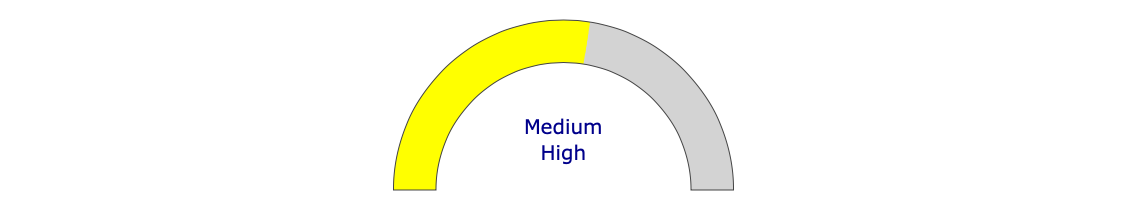

In [3]:
DMPlots

In [2]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

app = dash.Dash(__name__)

# Define styles for the boxes with a new neutral yet vibrant palette
BOX_STYLE = {
    'width': '140px',
    'height': '140px',
    'display': 'inline-block',
    'textAlign': 'center',
    'lineHeight': '140px',
    'margin': '10px',
    'border': '2px solid #aaa',
    'borderRadius': '12px',
    'cursor': 'pointer',
    'fontWeight': 'bold',
    'fontSize': '22px',  # Larger text for better readability
    'color': '#333',
    'transition': 'all 0.3s ease',
    'backgroundColor': '#f4f4f4',
    'boxShadow': '1px 1px 5px rgba(0,0,0,0.1)'
}

# Improved vibrant yet neutral color palette
BOX_STYLES_FULL = {
    'large': {**BOX_STYLE, 'backgroundColor': '#AEC6CF'},  # Soft cyan
    'medium': {**BOX_STYLE, 'backgroundColor': '#FFB347'},  # Warm orange
    'small': {**BOX_STYLE, 'backgroundColor': '#B39EB5'},  # Muted lavender
    'micro': {**BOX_STYLE, 'backgroundColor': '#FDFD96'}   # Light pastel yellow
}

# Hover style for boxes
HOVER_STYLE = {
    'transform': 'scale(1.05)',
    'boxShadow': '3px 3px 8px rgba(0,0,0,0.15)'
}

app.layout = html.Div([
    html.Div([
        html.Div("Large", id="large-box", style=COLORFUL_STYLES['large']),
        html.Div("Medium", id="medium-box", style=COLORFUL_STYLES['medium']),
    ], style={'display': 'flex', 'justifyContent': 'center'}),
    
    html.Div([
        html.Div("Small", id="small-box", style=COLORFUL_STYLES['small']),
        html.Div("Micro", id="micro-box", style=COLORFUL_STYLES['micro']),
    ], style={'display': 'flex', 'justifyContent': 'center'}),

    html.Div(id='output-click', style={'marginTop': '20px', 'fontSize': '24px', 'fontStyle': 'italic', 'color': '#555'})  # Larger feedback text
])

# Callback to capture click and apply hover effect
@app.callback(
    [Output('output-click', 'children'),
     Output('large-box', 'style'),
     Output('medium-box', 'style'),
     Output('small-box', 'style'),
     Output('micro-box', 'style')],
    [Input('large-box', 'n_clicks'),
     Input('medium-box', 'n_clicks'),
     Input('small-box', 'n_clicks'),
     Input('micro-box', 'n_clicks')]
)
def update_output(large_clicks, medium_clicks, small_clicks, micro_clicks):
    ctx = dash.callback_context
    # Apply hover effect to boxes
    updated_styles = {
        'large': {**COLORFUL_STYLES['large']},
        'medium': {**COLORFUL_STYLES['medium']},
        'small': {**COLORFUL_STYLES['small']},
        'micro': {**COLORFUL_STYLES['micro']},
    }
    if not ctx.triggered:
        return "Click on a box", updated_styles['large'], updated_styles['medium'], updated_styles['small'], updated_styles['micro']
    else:
        clicked_box = ctx.triggered[0]['prop_id'].split('.')[0]
        updated_styles[clicked_box.replace('-box', '')].update(HOVER_STYLE)
        return f'You clicked: {clicked_box.replace("-box", "").capitalize()}', \
               updated_styles['large'], updated_styles['medium'], updated_styles['small'], updated_styles['micro']

if __name__ == '__main__':
    app.run_server(debug=True)


NameError: name 'COLORFUL_STYLES' is not defined

In [1]:




# Initial name layout
initial_name_elements = [
    html.Div(children=row["Names"],
             id={'type': 'name-bubble', 'index': row["Names"]},
             style={**NAME_BUBBLE_STYLE,
                    'backgroundColor': category_colors[row['Category']],
                    'textColor': '#000'},
             className='bubble'
             ) for _, row in df.iterrows()]








# Callback to update the name bubbles to reflect user selection
@app.callback(
    Output('names-container', 'children'),
    Output('selected-names', 'data'),
    Input('btn-green', 'n_clicks'),
    Input('btn-yellow', 'n_clicks'),
    Input('btn-orange', 'n_clicks'),
    Input('btn-red', 'n_clicks'),
    Input({'type': 'name-bubble', 'index': ALL}, 'n_clicks'),
    State('names-container', 'children'),
    State('selected-names', 'data'),
)
def update_name_bubbles(green_btn, yellow_btn, orange_btn, red_btn,
                        name_clicks, names_container, selected_status):
    ctx = dash.callback_context
    if not ctx.triggered:
        return dash.no_update, dash.no_update

    clicked_id = ctx.triggered[0]['prop_id'].split('.')[0]

    # Handle color category click
    if clicked_id.startswith('btn-'):  # Check that a color button was clicked
        category_clicked = clicked_id.split('-')[1].capitalize()  # Extract color category
        toggle_select = not all([selected_status[name] for name in df[df["Category"] == category_clicked]["Names"]])

        for name in df[df['Category'] == category_clicked]['Names']:
            selected_status[name] = toggle_select

        updated_name_elements = [
            html.Div(children=row["Names"],
                     id={'type': 'name-bubble', 'index': row["Names"]},
                     style={**NAME_BUBBLE_STYLE,
                            'backgroundColor': category_colors['Selected'] if selected_status[row['Names']] else category_colors[row['Category']],
                            'color': category_colors[row['Category']] if selected_status[row['Names']] else '#000'},
                     className='bubble'
                     ) for _, row in df.iterrows()]

        return updated_name_elements, selected_status

    if 'name-bubble' in clicked_id:
        name_clicked = json.loads(clicked_id)['index']
        selected_status[name_clicked] = not selected_status[name_clicked]

        updated_name_elements = [
            html.Div(children=row["Names"],
                     id={'type': 'name-bubble', 'index': row["Names"]},
                     style={**NAME_BUBBLE_STYLE,
                            'backgroundColor': category_colors['Selected'] if selected_status[row['Names']] else category_colors[row['Category']],
                            'color': category_colors[row['Category']] if selected_status[row['Names']] else '#000'},
                     className='bubble'
                     ) for _, row in df.iterrows()]

        return updated_name_elements, selected_status

    return dash.no_update, selected_status


# Combined callback for "Okay" and "Next" button
@app.callback(
    Output('grid-output', 'children'),
    Output('names-container', 'style'),
    Output('next-button', 'style'),
    Output('selected-companies', 'data'),
    Output('page', 'data'),
    Input('okay-button', 'n_clicks'),
    Input('next-button', 'n_clicks'),
    State('selected-names', 'data'),
    State('selected-companies', 'data'),
    State('page', 'data')
)
def display_and_switch_grid(okay_clicks, next_clicks, selected_names, selected_companies, page):
    ctx = dash.callback_context
    if not ctx.triggered:
        return dash.no_update, dash.no_update, dash.no_update, dash.no_update, dash.no_update

    triggered_id = ctx.triggered[0]['prop_id'].split('.')[0]

    if triggered_id == 'okay-button':
        selected_companies = [name for name, selected in selected_names.items() if selected]
        if not selected_companies:
            return 'No companies selected.', {'display': 'none'}, {'display': 'none'}, [], 0

        first_company = selected_companies[0]
        company_data = df[df['Names'] == first_company].iloc[0]

        # Create cards for each data item
        cards = html.Div([
            html.H1(children = company_data["Names"], style = {'text-align': 'center', 'font-size': '36px'}),
            html.Div([  ## Row 1
                html.Div([
                    html.H3("Company Sales", style = {'text-align' : 'center', 'font-size': '28px'}),
                    dcc.Graph(figure = create_background_line_plot(company_data[["Sales_5", "Sales_4", "Sales_3", "Sales_2", "Sales_1", "Sales"]].values.tolist()),
                              config={'displayModeBar': False},
                              style={'position': 'absolute', 'top': '20px', 'left': '20px', 'width': 'calc(100% - 40px)', 'height': 'calc(100% - 40px)', 'z-index': '0'},
                              id=f'graph1-{page}'),
                    html.P(company_data["Sales"], style={'text-align': 'center', 'font-size': '24px', 'position': 'relative', 'z-index': '1'}),
                ], style = CARD_STYLE),
                html.Div([
                    html.H3("Assets", style = {'text-align' : 'center', 'font-size': '28px'}),
                    dcc.Graph(figure = create_background_line_plot(company_data[["Assets_5", "Assets_4", "Assets_3", "Assets_2", "Assets_1", "Assets"]].values.tolist()),
                              config={'displayModeBar': False},
                              style={'position': 'absolute', 'top': '20px', 'left': '20px', 'width': 'calc(100% - 40px)', 'height': 'calc(100% - 40px)', 'z-index': '0'},
                             id=f'graph2-{page}'),
                    html.P(company_data["Assets"], style={'text-align': 'center', 'font-size': '24px', 'position': 'relative', 'z-index': '1'}),
                ], style = CARD_STYLE),
            ], style={'display': 'flex'}),
            html.Div([ ## Row 2
                html.Div([
                    html.H3("Sector", style={'text-align': 'center', 'font-size': '28px'}),
                    html.P(company_data["Sector"], style={'text-align': 'center', 'font-size': '24px'}),
                ], style = CARD_STYLE),
                html.Div([
                    html.H3("Industry", style={'text-align': 'center', 'font-size': '28px'}),
                    html.P(company_data["Industry"], style={'text-align': 'center', 'font-size': '24px'}),
                ], style = CARD_STYLE),
                html.Div([
                    html.H3("Country", style={'text-align': 'center', 'position': 'relative', 'z-index': '1', 'font-size': '28px'}),
                    html.P(company_data["Geography"], style={'text-align': 'center', 'font-size': '24px', 'position': 'relative', 'z-index': '1'}),
                    dcc.Graph(figure = create_country_silhouette(company_data["Geography"]), 
                              config={'displayModeBar': False}, 
                              style={'position': 'absolute', 'top': '0', 'left': '0', 'width': '100%', 'height': '100%', 'z-index': '0', 'opacity': '0.1'}),
                ], style = CARD_STYLE),
                html.Div([
                    html.H3("Company Size", style={'text-align': 'center', 'font-size': '28px'}),
                    html.P(company_data["Size"], style={'text-align': 'center', 'font-size': '24px'}),
                ], style = CARD_STYLE),
            ], style={'display': 'flex'}),
            html.Div([ ## Row 3
                html.Div([
                    html.H3("Sales Probability", style={'text-align': 'center', 'font-size': '28px'}),
                    dcc.Graph(figure = create_speedometer(company_data["SalesP"])),
                    html.P(company_data["SalesP"], style={'text-align': 'center', 'font-size': '24px', 'margin-top': '5px'}),
                ], style=CARD_STYLE),
                html.Div([
                    html.H3("Asset Probability", style={'text-align': 'center', 'font-size': '28px'}),
                    dcc.Graph(figure = create_speedometer(company_data["AssetP"])),
                    html.P(company_data["AssetP"], style={'text-align': 'center', 'font-size': '24px', 'margin-top': '5px'}),
                ], style=CARD_STYLE),
                html.Div([
                    html.H3("Debt Probability", style={'text-align': 'center', 'font-size': '28px'}),
                    dcc.Graph(figure = create_speedometer(company_data["DebtP"])),
                    html.P(company_data["DebtP"], style={'text-align': 'center', 'font-size': '24px', 'margin-top': '5px'}),
                ], style=CARD_STYLE),
                html.Div([
                    html.H3("Shrinkage Probability", style={'text-align': 'center', 'font-size': '28px'}),
                    dcc.Graph(figure = create_speedometer(company_data["ShrinkageP"])),
                    html.P(company_data["ShrinkageP"], style={'text-align': 'center', 'font-size': '24px', 'margin-top': '5px'}),
                ], style=CARD_STYLE),
            ], style={'display': 'flex'}),
            html.Div([ ## Row 4
                html.H3("Sales Drivers", style={'text-align': 'center', 'font-size': '28px'}),
                dcc.Graph(figure = bar_heatmap(company_data, percentiles, custom_color_map_101), id=f'graph-bar-{page}')
            ]),
        ])

        return cards, {'display': 'none'}, {'display': 'block'}, selected_companies, 0

    elif triggered_id == 'next-button':
        if selected_companies:
            page = (page + 1) % len(selected_companies)
            company = selected_companies[page]
            company_data = df[df['Names'] == company].iloc[0]

            # Create cards for each data item
            cards = html.Div([
            html.H1(children = company_data["Names"], style = {'text-align': 'center', 'font-size': '36px'}),
            html.Div([  ## Row 1
                html.Div([
                    html.H3("Company Sales", style = {'text-align' : 'center', 'font-size': '28px'}),
                    dcc.Graph(figure = create_background_line_plot(company_data[["Sales_5", "Sales_4", "Sales_3", "Sales_2", "Sales_1", "Sales"]].values.tolist()),
                              config={'displayModeBar': False},
                              style={'position': 'absolute', 'top': '20px', 'left': '20px', 'width': 'calc(100% - 40px)', 'height': 'calc(100% - 40px)', 'z-index': '0'},
                              id=f'graph1-{page}'),
                    html.P(company_data["Sales"], style={'text-align': 'center', 'font-size': '24px', 'position': 'relative', 'z-index': '1'}),
                ], style = CARD_STYLE),
                html.Div([
                    html.H3("Assets", style = {'text-align' : 'center', 'font-size': '28px'}),
                    dcc.Graph(figure = create_background_line_plot(company_data[["Assets_5", "Assets_4", "Assets_3", "Assets_2", "Assets_1", "Assets"]].values.tolist()),
                              config={'displayModeBar': False},
                              style={'position': 'absolute', 'top': '20px', 'left': '20px', 'width': 'calc(100% - 40px)', 'height': 'calc(100% - 40px)', 'z-index': '0'},
                              id=f'graph2-{page}'),
                    html.P(company_data["Assets"], style={'text-align': 'center', 'font-size': '24px', 'position': 'relative', 'z-index': '1'}),
                ], style = CARD_STYLE),
            ], style={'display': 'flex'}),
            html.Div([ ## Row 2
                html.Div([
                    html.H3("Sector", style={'text-align': 'center', 'font-size': '28px'}),
                    html.P(company_data["Sector"], style={'text-align': 'center', 'font-size': '24px'}),
                ], style = CARD_STYLE),
                html.Div([
                    html.H3("Industry", style={'text-align': 'center', 'font-size': '28px'}),
                    html.P(company_data["Industry"], style={'text-align': 'center', 'font-size': '24px'}),
                ], style = CARD_STYLE),
                html.Div([
                    html.H3("Country", style={'text-align': 'center', 'position': 'relative', 'z-index': '1', 'font-size': '28px'}),
                    html.P(company_data["Geography"], style={'text-align': 'center', 'font-size': '24px', 'position': 'relative', 'z-index': '1'}),
                    dcc.Graph(figure = create_country_silhouette(company_data["Geography"]), 
                              config={'displayModeBar': False}, 
                              style={'position': 'absolute', 'top': '0', 'left': '0', 'width': '100%', 'height': '100%', 'z-index': '0', 'opacity': '0.1'}),
                ], style = CARD_STYLE),
                html.Div([
                    html.H3("Company Size", style={'text-align': 'center', 'font-size': '28px'}),
                    html.P(company_data["Size"], style={'text-align': 'center', 'font-size': '24px'}),
                ], style = CARD_STYLE),
            ], style={'display': 'flex'}),
            html.Div([ ## Row 3
                html.Div([
                    html.H3("Sales Probability", style={'text-align': 'center', 'font-size': '28px'}),
                    dcc.Graph(figure = create_speedometer(company_data["SalesP"])),
                    # html.P(company_data["SalesP"], style={'text-align': 'center', 'font-size': '24px', 'margin-top': '5px'}),
                ], style={**CARD_STYLE, 'padding': '5px'}),
                html.Div([
                    html.H3("Asset Probability", style={'text-align': 'center', 'font-size': '28px'}),
                    dcc.Graph(figure = create_speedometer(company_data["AssetP"])),
                    # html.P(company_data["AssetP"], style={'text-align': 'center', 'font-size': '24px', 'margin-top': '5px'}),
                ], style={**CARD_STYLE, 'padding': '5px'}),
                html.Div([
                    html.H3("Debt Probability", style={'text-align': 'center', 'font-size': '28px'}),
                    dcc.Graph(figure = create_speedometer(company_data["DebtP"])),
                    # html.P(company_data["DebtP"], style={'text-align': 'center', 'font-size': '24px', 'margin-top': '5px'}),
                ], style={**CARD_STYLE, 'padding': '5px'}),
                html.Div([
                    html.H3("Shrinkage Probability", style={'text-align': 'center', 'font-size': '28px'}),
                    dcc.Graph(figure = create_speedometer(company_data["ShrinkageP"])),
                    # html.P(company_data["ShrinkageP"], style={'text-align': 'center', 'font-size': '24px', 'margin-top': '5px'}),
                ], style={**CARD_STYLE, 'padding': '5px'}),
            ], style={'display': 'flex'}),
            # html.Div([ ## Row 4
            #     html.H3("Sales Drivers", style={'text-align': 'center', 'font-size': '28px'}),
            #     dcc.Graph(figure = bar_heatmap(company_data, percentiles, custom_color_map_101), id=f'graph-bar-{page}'),
            #     html.Div([html.Img(src=f"data:image/png;base64,{create_radial_graph()}")], style={'textAlign': 'center', 'marginTop': '20px'}),
            # ]),
            # Update Row 4 Layout with Fixed Card Sizes (50% each)
            html.Div([  # Row 4
                html.Div([ # Left 
                    html.Div([
                        html.H3("Sales Drivers Heatmap", style={'text-align': 'center', 'font-size': '24px', 'margin-bottom': '10px'}),
                        dcc.Graph(figure=bar_heatmap(company_data, percentiles, custom_color_map_101), id=f'graph-bar-{page}', 
                                  style={'height': '300px', 'width': '100%', 'padding': '10px'}) # Fix the height of the graph
                    ], style={'width': '100%', 'height': '100%', 'padding': '10px', 'box-sizing': 'border-box'})
                ], style={
                    'width': '65%', 
                    'background-color': '#e8f4f8', 
                    'margin': '10px', 
                    'box-shadow': '2px 2px 5px rgba(0,0,0,0.1)', 
                    'border-radius': '10px', 
                    'max-height': '400px',  # Limit the card height
                    'overflow': 'hidden'  # Prevent content overflow
                }),
                html.Div([
                    html.Div([
                        html.H3("Sales Drivers Radial Graph", style={'text-align': 'center', 'font-size': '24px', 'margin-bottom': '10px'}),
                        html.Img(src=f"data:image/png;base64,{create_radial_graph()}", 
                                 style={'height': '300px', 'width': '100%', 'object-fit': 'contain'})  # Set a fixed height and ensure image fits properly
                    ], style={'width': '100%', 'height': '100%', 'padding': '10px', 'box-sizing': 'border-box', 'background-color': '#e8f4f8'})
                ], style={
                    'width': '35%', 
                    'background-color': '#e8f4f8', 
                    'margin': '10px', 
                    'box-shadow': '2px 2px 5px rgba(0,0,0,0.1)', 
                    'border-radius': '10px', 
                    'max-height': '400px',  # Limit the card height
                    'overflow': 'hidden'  # Prevent content overflow
                }),
            ], style={
                'display': 'flex', 
                # 'justify-content': 'space-between', 
                # 'align-items': 'center', 
                # 'width': '100%', 
                # 'max-width': '1200px',  # Limit the total row width for better control
                # 'margin': 'auto'
            }),
            html.Div([  # Row 4
                html.Div([
                    html.Div([
                        html.H3("Sales Drivers Radial Graph", style={'text-align': 'center', 'font-size': '24px', 'margin-bottom': '10px'}),
                        html.Img(src=f"data:image/png;base64,{create_radial_graph()}", 
                                 style={'height': '300px', 'width': '100%', 'object-fit': 'contain'})  # Set a fixed height and ensure image fits properly
                    ], style={'width': '100%', 'height': '100%', 'padding': '10px', 'box-sizing': 'border-box'})
                ], style={
                    'width': '35%', 
                    'background-color': '#e8f4f8', 
                    'margin': '10px', 
                    'box-shadow': '2px 2px 5px rgba(0,0,0,0.1)', 
                    'border-radius': '10px', 
                    'max-height': '400px',  # Limit the card height
                    'overflow': 'hidden'  # Prevent content overflow
                }),
                html.Div([ 
                    html.Div([
                        html.H3("Sales Drivers Heatmap", style={'text-align': 'center', 'font-size': '24px', 'margin-bottom': '10px'}),
                        dcc.Graph(figure=bar_heatmap(company_data, percentiles, custom_color_map_101), id=f'graph-bar-{page}', 
                                  style={'height': '300px', 'width': '100%', 'padding': '10px'}) # Fix the height of the graph
                    ], style={'width': '100%', 'height': '100%', 'padding': '10px', 'box-sizing': 'border-box'})
                ], style={
                    'width': '65%', 
                    'background-color': '#e8f4f8', 
                    'margin': '10px', 
                    'box-shadow': '2px 2px 5px rgba(0,0,0,0.1)', 
                    'border-radius': '10px', 
                    'max-height': '400px',  # Limit the card height
                    'overflow': 'hidden'  # Prevent content overflow
                }),
            ], style={
                'display': 'flex', 
                # 'justify-content': 'space-between', 
                # 'align-items': 'center', 
                # 'width': '100%', 
                # 'max-width': '1200px',  # Limit the total row width for better control
                # 'margin': 'auto'
            })

        ])

            return cards, dash.no_update, dash.no_update, dash.no_update, page

    return dash.no_update, dash.no_update, dash.no_update, dash.no_update, dash.no_update

# Run app
if __name__ == '__main__':
    app.run_server(debug=True)

NameError: name 'df' is not defined

In [ ]:
page = (page + 1) % len(selected_companies)

In [1]:
page = 20

In [3]:
(30 + 1) % 30

1

In [4]:
import Setup

In [5]:
mp = Setup.df.iloc[0]

In [15]:
mp.iloc[:20]

Names              Name1
Sales        1007.942844
Asset        1919.938326
Sector              Tech
Industry            Tech
Geography            USA
Size               Large
SalesP                33
AssetP                36
ShrinkP               27
BorrowP               10
Sales_1       884.923353
Sales_2       879.015201
Sales_3        827.06485
Sales_4       824.847164
Sales_5        893.36341
Asset_1       1845.43528
Asset_2      1825.253749
Asset_3      1771.388977
Asset_4      1544.900039
Name: 0, dtype: object

In [16]:
mlp = ["Sales_1", "ShrinkP", "A_Asset"]
mlp

['Sales_1', 'ShrinkP', 'A_Asset']

In [17]:
mp[mlp]

Sales_1    884.923353
ShrinkP            27
A_Asset     57.665873
Name: 0, dtype: object

In [18]:
lmp = "Name1;Name2;Name3;Name4;Name7;Name20"

In [19]:
lmp.split(";")

['Name1', 'Name2', 'Name3', 'Name4', 'Name7', 'Name20']